In [1]:
import sys
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from sklearn import svm
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn import model_selection as ms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy import stats
from random import *
from tensorflow.keras import utils
print(tf.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

2.3.0


In [2]:
print(tf.__version__)

2.3.0


### Input값과 실제 값의 차이 확인

In [3]:
raw_diff = pd.read_excel('Data_preprocessing5.xlsx')

#Input과 실제 값의 차이 column 생성
diff = raw_diff.copy()
diff['Difference'] = abs(diff['Input_T'] - diff['Thickness'])

pp_diff = diff[diff['PP'] == 1] # pp층
ccl_diff = diff[diff['PP'] ==0] # ccl층

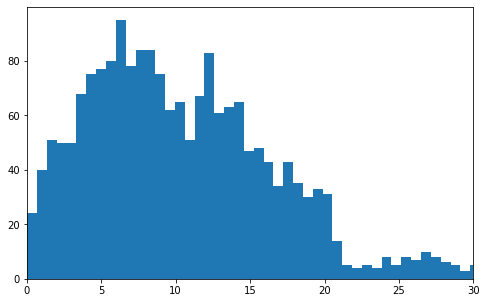

In [4]:
#PP층의 Input값과 실제 값 차이 시각화
plt.figure(figsize=(8,5))
plt.hist(pp_diff['Difference'], bins = 50)
plt.xlim([0,30])
plt.show()

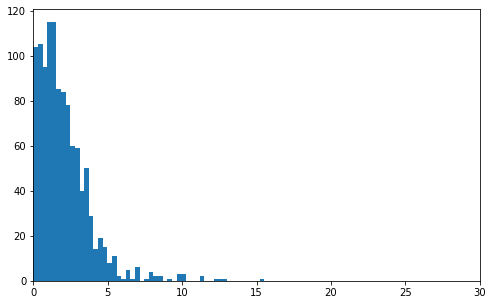

In [5]:
#CCL층의 Input값과 실제 값 차이 시각화
plt.figure(figsize=(8,5))
plt.hist(ccl_diff['Difference'], bins = 50)
plt.xlim([0,30])
plt.show()

## RNN

### 데이터 전처리

In [6]:
raw_data = pd.read_excel('Data_preprocessing6.xlsx')
data = raw_data.copy()

#결측치 0으로 대체
data = data.fillna(0)
data_rnn = data.copy()

#예측에 사용되지 않는 칼럼은 제거
data_rnn = data_rnn.drop(['PP','MatlMaker','MatlNum','CCL1','CCL2'],axis='columns')
data_rnn.head()

,Model,LayerNum,RD,GD,RC,MatlG,Cu1,CP1,Cu2,CP2,Input_T,Thickness
0,1,1,1.36,2.56,61,46.8,8.21,55,14.29,73,60,67.70
1,1,3,1.36,2.56,47,203.4,15.04,56,14.58,46,200,187.25
2,1,5,1.36,2.56,53,81.4,14.29,75,15.04,48,90,80.48
3,1,7,1.36,2.56,53,81.4,14.29,48,14.29,75,90,81.44
4,1,9,1.36,2.56,47,203.4,15.04,50,15.80,60,200,193.23


In [7]:
#sequence data 생성
def make_seq(data_rnn):
    # 모델별로 sequence 생성위해 범위 설정
    range_ = data_rnn['Model'].unique().tolist()
    a =[]
    seq_all = []

    for i in range_:
        #모델별로 데이터 생성 
        globals()['data_{}'.format(i)] = data_rnn[data_rnn['Model'] == i]
        globals()['data_{}'.format(i)].reset_index(drop = True, inplace=True)
        
        #모델에서 층만 분류 --> 나중에 제로패딩을 위한 작업
        a.append(len(globals()['data_{}'.format(i)]['LayerNum'].unique()))

        # 모델별로 생성한 데이터에서 제품 하나씩 분리
        l1 = len(globals()['data_{}'.format(i)]['LayerNum'].unique())
        l2 = len(globals()['data_{}'.format(i)])
        l3 = int(l2/l1)

        # seq_a_b : a모델의 b번째 제품
        for j in range(1, l3+1):
            globals()['seq_{}_{}'.format(i,j)] = globals()['data_{}'.format(i)].copy().iloc[l1*(j-1):l1*j]
            globals()['seq_{}_{}'.format(i,j)].drop(['Model'], axis='columns', inplace=True)
            seq_all.append(globals()['seq_{}_{}'.format(i,j)])

    maxlen = max(a) #최대 층 갯수 저장 --> 제로패딩을 위한 작업
    
    return range_ , seq_all, maxlen

In [8]:
def make_dataset(data_rnn):
    range_, seq_all, maxlen = make_seq(data_rnn)
    dataset = []

    #제품 Layer층이 제일 큰 기준에 맞춰 zero padding 실시
    for i in range(1,len(range_)+1):
        l1 = len(globals()['data_{}'.format(i)]['LayerNum'].unique())
        l2 = len(globals()['data_{}'.format(i)])
        l3 = int(l2/l1)

        for j in range(1, l3+1):  
            size0 = globals()['seq_{}_{}'.format(i,j)].shape[0] #각 sequence의 행의 수
            size1 = globals()['seq_{}_{}'.format(i,j)].shape[1] #각 sequence의 열의 수
            #최대 행의 수에서 현재 sequence의 행의 수를 뺀 만큼 패딩
            pad = pd.DataFrame([[0]*size1],columns=globals()['seq_{}_{}'.format(i,j)].columns, index = range(maxlen - size0))
            globals()['seq_{}_{}'.format(i,j)] = pd.concat([globals()['seq_{}_{}'.format(i,j)], pad]).reset_index(drop=True)
            dataset.append(globals()['seq_{}_{}'.format(i,j)])
    return dataset

In [9]:
dataset = make_dataset(data_rnn)

### Train/Test dataset 분리

In [10]:
def train_test_set(dataset):
    train_len = int(0.8 * len(dataset))
    
    # 전체 데이터 셋의 80% 무작위 추출
    np.random.seed(10)
    p = np.random.choice(len(dataset), train_len , replace=False)
    train_dataset = [dataset[i] for i in p]
    
    # 나머지 20% 추출
    q = [i for i in range(len(dataset)) if i not in p]
    test_dataset = [dataset[i] for i in q]
    
    # 하나로 통합
    for i in range(len(p)-1):
        train_dataset[0] = train_dataset[0].append(train_dataset[i+1])

    for i in range(len(q)-1):
        test_dataset[0] = test_dataset[0].append(test_dataset[i+1])
        
    #두께를 y값으로 나머지를 x값으로 설정
    train_seq_x = train_dataset[0].drop('Thickness', axis = 1)
    train_seq_y = train_dataset[0]['Thickness']
    
    test_seq_x = test_dataset[0].drop('Thickness', axis = 1)
    test_seq_y = test_dataset[0]['Thickness']
    
    # RNN Input 형태에 맞추기 위해 reshape
    temp, temp2, maxlen = make_seq(data_rnn)
    train_seq_x2 = train_seq_x.values.reshape(-1,maxlen,train_seq_x.shape[1])
    train_seq_y2 = train_seq_y.values.reshape(-1,maxlen,1)

    test_seq_x2 = test_seq_x.values.reshape(-1,maxlen,test_seq_x.shape[1])
    test_seq_y2 = test_seq_y.values.reshape(-1,maxlen,1)
    
    return train_seq_x2, train_seq_y2, test_seq_x2, test_seq_y2

In [11]:
train_seq_x2, train_seq_y2, test_seq_x2, test_seq_y2 = train_test_set(dataset)

### SimpleRNN Modeling

In [12]:
#예측 모델 생성
def build_model():
    #SimpleRNN 모델 설정, input사이즈는 데이터에 따라 유동적일 수 있도록 설정
    #return_sequences = Ture를 통해 각 층마다 결과값 도출
    model = keras.Sequential()
    model.add(SimpleRNN(32, input_shape=(train_seq_x2.shape[1],train_seq_x2.shape[2]),return_sequences = True))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))
    
    adam = optimizers.Adam(lr = 0.001)

    model.compile(loss='mse',
                optimizer=adam,
                metrics=['mae', 'mse'])
    
    return model

In [13]:
model = build_model()

In [14]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 200

In [15]:
history = model.fit(train_seq_x2, train_seq_y2,epochs=EPOCHS, validation_split = 0.3, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

### Training 시각화

In [16]:
import matplotlib.pyplot as plt

#Epoch 변화에 따른 Training data, Validation data의 MAE, MSE 변화 파악
def plot_history(history):
    hist= pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#     plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#     plt.ylim([0,200])
    plt.legend()
    plt.show()

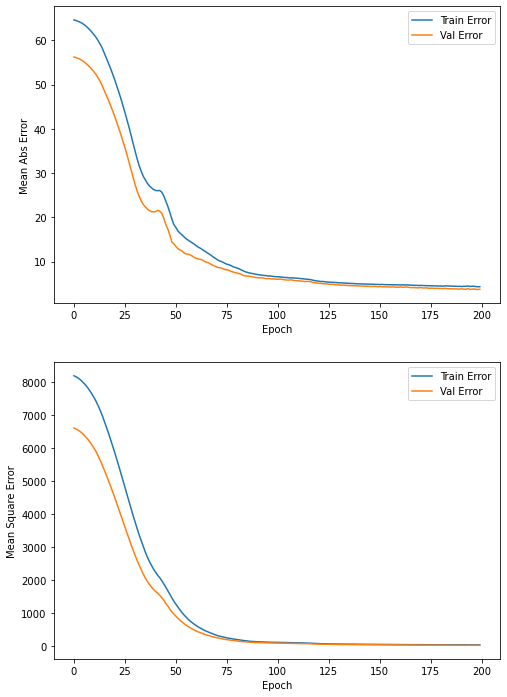

In [17]:
plot_history(history)

In [18]:
test_predictions = model.predict(test_seq_x2)

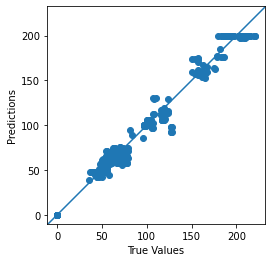

In [19]:
# 실제 값과 예측 값의 차이를 y=x 직선 위에 표현
plt.scatter(test_seq_y2,test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.plot([-100, 250], [-100, 250])

### R-squared

In [20]:
#R-squared 값 계산
def val(test_predictions):
    se = test_seq_y2 - test_predictions
    se2 = se ** 2
    s = sum(i for i in se2)

    st = test_seq_y2 - sum(test_seq_y2)/64
    st2 = st ** 2
    t = sum(i for i in st2)

    r_sqr = 1 - (s/t)
    return r_sqr

In [21]:
#각 층마다 R-squared 값 계산
val(test_predictions)

array([[0.84715159],
       [0.98291068],
       [0.96166042],
       [0.9680995 ],
       [0.9714486 ],
       [0.98567321],
       [0.98711601],
       [0.9882225 ],
       [0.96995879]])

### 오차 그래프 시각화

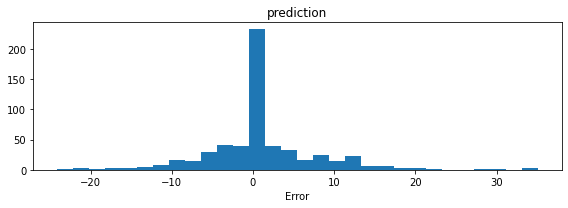

In [22]:
# 예측값과 실제값의 차이 그래프로 표현
plt.figure(figsize=(8, 3))
plt.hist((test_seq_y2 - test_predictions).flatten(), bins = 30)
plt.xlabel("Error")
plt.title("prediction")
plt.tight_layout()
plt.show()

### Bidirectional RNN Modeling

In [23]:
def build_model2():
    model2 = keras.Sequential()
    model2.add(layers.Bidirectional(SimpleRNN(32, input_shape = (train_seq_x2.shape[1],train_seq_x2.shape[2]), return_sequences = True)))
    model2.add(layers.Dense(8, activation='relu'))
    model2.add(layers.Dense(8, activation='relu'))
    model2.add(layers.Dense(1))
    
    adam = optimizers.Adam(lr = 0.001)

    model2.compile(loss='mse',
                optimizer=adam,
                metrics=['mae', 'mse'])
    
    return model2

In [24]:
model2 = build_model2()

In [25]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 200

In [26]:
history2 = model2.fit(train_seq_x2, train_seq_y2,epochs=EPOCHS, validation_split = 0.3, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

### Training 시각화

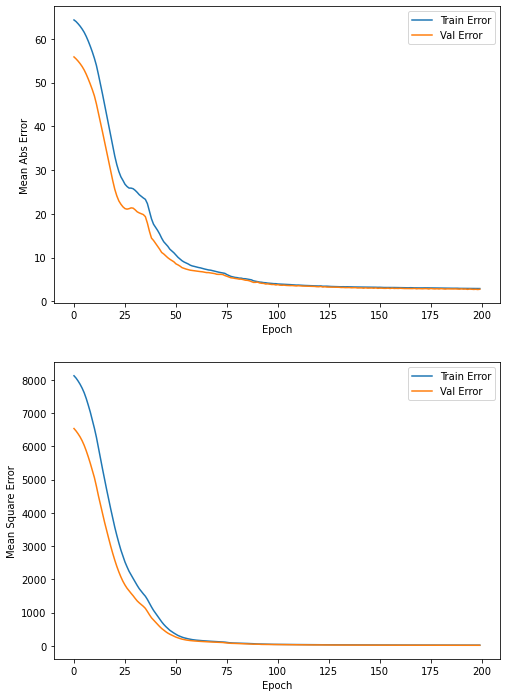

In [27]:
plot_history(history2)

In [28]:
test_predictions2 = model2.predict(test_seq_x2)

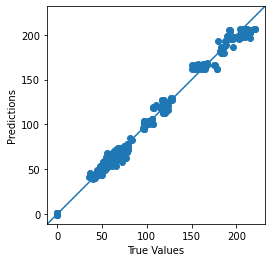

In [29]:
plt.scatter(test_seq_y2, test_predictions2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.plot([-100, 250], [-100, 250])

### R-squared

In [30]:
val(test_predictions2)

array([[0.94369216],
       [0.98801548],
       [0.98881046],
       [0.9886112 ],
       [0.99176444],
       [0.99079401],
       [0.99697964],
       [0.99689674],
       [0.97908454]])

### 오차 그래프 시각화

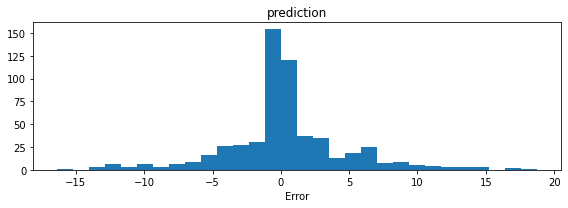

In [31]:
plt.figure(figsize=(8, 3))
plt.hist((test_seq_y2 - test_predictions2).flatten(), bins = 30)
plt.xlabel("Error")
plt.title("prediction")
plt.tight_layout()
plt.show()

In [32]:
sum(abs(test_seq_y2 - test_predictions2)/64)

array([[2.58268024],
       [5.29258218],
       [4.31434942],
       [4.58537119],
       [3.87097495],
       [2.694758  ],
       [1.11585415],
       [0.59582026],
       [0.5066038 ]])

In [33]:
sum((test_seq_y2-test_predictions2).reshape(64,9))/64

array([ 0.2423037 ,  1.40904736,  0.95256819, -0.10370815,  1.13659794,
       -1.0279164 , -0.22076611,  0.41852215,  0.47865368])

In [34]:
abs_value = sum((abs(test_seq_y2-test_predictions2).reshape(64,9)))/64

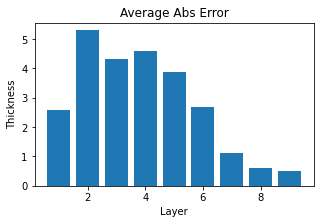

In [35]:
#각 층마다 예측값과 실제값의 차이 그래프로 표현
plt.figure(figsize=(5, 3))
plt.bar(range(1,10),abs_value)
plt.xlabel("Layer")
plt.ylabel("Thickness")
plt.title("Average Abs Error")
# plt.tight_layout()
plt.show()